# Step 2: Controlled Generation of Small Molecules with `GenMol` and cLogP

### RORc Nuclear Receptor Antagonist Case-Study
Rene, O.; *et al*. "[Minor Structural Change to Tertiary Sulfonamide RORc Ligands Led to Opposite Mechanisms of Action.](https://pubs.acs.org/doi/10.1021/ml500420y)" *ACS Med. Chem. Lett.* **2015**, *6*, 276-281.

[GenMol](https://arxiv.org/abs/2501.06158) is a masked diffusion model trained on molecular [Sequential Attachment-based Fragment Embedding (SAFE)](https://arxiv.org/abs/2310.10773) representations for fragment-based molecule generation. GenMol can serve as a generalist model for various drug discovery tasks, including *de novo* molecular generation​, linker design​, motif extension​, scaffold decoration/morphing​, hit generation​, and lead optimization.

**cLogP** as an optimization criteria for drug discovery:
1. Leeson, P. D.; Springthorpe, B. "[The Influence of Drug-Like Concepts on
Decision-Making in Medicinal Chemistry.](https://www.nature.com/articles/nrd2445)" *Nat. Rev. Drug Discov.* **2007**, *6*, 881-890.
2. Pennington, L. D.; *et al.* "[Property-Based Drug Design Merits a Nobel Prize](https://pubs.acs.org/doi/10.1021/acs.jmedchem.4c01345)." *J. Med. Chem.* **2024**, *67*, 11452-11458.

## 2.1 Set Up the Environment

In [67]:
!pip install rdkit python-dotenv pandas numpy matplotlib loguru py3dmol safe-mol datamol


In [68]:
import pickle
import numpy as np
import pandas as pd
import random
import os, shutil, requests
import matplotlib.pyplot as plt
from typing import List
from IPython.display import display, clear_output

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.QED import qed
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.DataStructs import TanimotoSimilarity
from google.colab import userdata

# SAFE to SMILES conversion
import safe as sf
import datamol as dm

In [69]:
class Slicer:
    def __call__(self, mol):
        if isinstance(mol, str):
            mol = Chem.MolFromSmiles(mol)

        bonds = mol.GetSubstructMatches(Chem.MolFromSmarts('[*]-;!@[*]'))
        for bond in bonds:
            yield bond

class Utils:

    @staticmethod
    def cut(smiles):
        def cut_nonring(mol):
            if not mol.HasSubstructMatch(Chem.MolFromSmarts('[*]-;!@[*]')):
                return None

            bis = random.choice(mol.GetSubstructMatches(Chem.MolFromSmarts('[*]-;!@[*]')))  # single bond not in ring
            bs = [mol.GetBondBetweenAtoms(bis[0], bis[1]).GetIdx()]
            fragments_mol = Chem.FragmentOnBonds(mol, bs, addDummies=True, dummyLabels=[(1, 1)])

            try:
                return Chem.GetMolFrags(fragments_mol, asMols=True, sanitizeFrags=True)
            except ValueError:
                return None

        mol = Chem.MolFromSmiles(smiles)
        frags = set()

        for _ in range(3):
            frags_nonring = cut_nonring(mol)
            if frags_nonring is not None:
                frags |= set([Chem.MolToSmiles(f) for f in frags_nonring])

        return frags

    @staticmethod
    def attach(frag1, frag2):
        rxn = AllChem.ReactionFromSmarts('[*:1]-[1*].[1*]-[*:2]>>[*:1]-[*:2]')
        mols = rxn.RunReactants((Chem.MolFromSmiles(frag1), Chem.MolFromSmiles(frag2)))
        return None if len(mols) == 0 else Chem.MolToSmiles(mols[np.random.randint(len(mols))][0])

    @staticmethod
    def smiles2safe(smiles):
        return sf.SAFEConverter(ignore_stereo=True).encoder(smiles, allow_empty=True)

    @staticmethod
    def attachable_points(fragment):
        return sf.utils.list_individual_attach_points(Chem.MolFromSmiles(fragment), depth=3)

## 2.2 Define the `SEED` Molecule

Example ligand based on **Compd 2** in Rene, O.; *et al*. "[Minor Structural Change to Tertiary Sulfonamide RORc Ligands Led to Opposite Mechanisms of Action.](https://pubs.acs.org/doi/10.1021/ml500420y)" *ACS Med. Chem. Lett.* **2015**, *6*, 276-281.

**Compd 2** was an antagonist with a RORc SRC1 EC<SUB>50</SUB> = 57 nM (-96% efficacy)

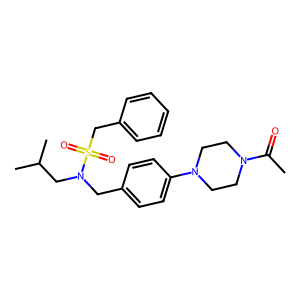

In [70]:
parent_ligand = "CC(C)CN(Cc1ccc(cc1)N2CCN(CC2)C(C)=O)[S](=O)(=O)Cc3ccccc3"
parent_mol = dm.to_mol(parent_ligand)
display(dm.to_image(parent_mol))

### Create modified SMILES, with "Fe" as exploration point on `SEED`

Ligand drawn with https://molview.org/ and exported as canonical SMILES string.

Set the exploration point at "Fe" so it is easy to find and edit in the resulting SMILES.


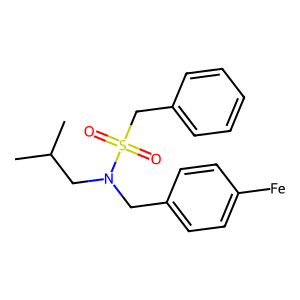

In [71]:
seed_smiles = "CC(C)CN(Cc1ccc([Fe])cc1)[S](=O)(=O)Cc2ccccc2"
seed_mol = dm.to_mol(seed_smiles)
display(dm.to_image(seed_mol))

In [72]:
safe_str = sf.encode(seed_mol)
print(f"SMILES: {seed_smiles}")
print(f"SAFE:   {safe_str}\n represented using {len(safe_str.split('.'))} fragments")

SMILES: CC(C)CN(Cc1ccc([Fe])cc1)[S](=O)(=O)Cc2ccccc2
SAFE:   c15cc[c]([Fe])cc1.c16ccccc1.S4(=O)(=O)C6.CC(C)C2.N234.C35
 represented using 6 fragments


### Ensure `safe` and `datamol` are functioning correctly

Reconstruct the fragments to ensure reconstruction matches original input

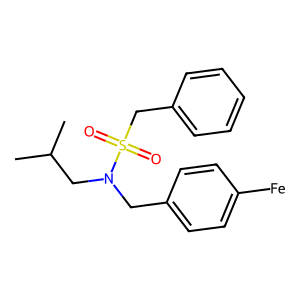

In [73]:
seed_reconstructed = dm.to_mol(safe_str)
display(dm.to_image(seed_reconstructed))

### Visualize `safe` deconstruction of SMILES into fragments

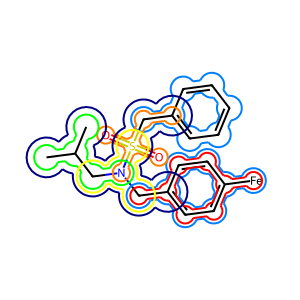

In [74]:
sf.to_image(safe_str)

### Edit SMILES of parent ligand to enable `GenMol`

Replace `[Fe]` in SMILES string with `[2*]`

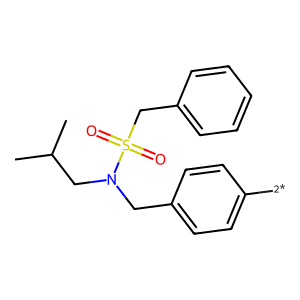

In [75]:
smiles = 'CC(C)CN(Cc1ccc([2*])cc1)[S](=O)(=O)Cc2ccccc2'
Draw.MolToImage(Chem.MolFromSmiles(smiles))

In [76]:
safe = Utils.smiles2safe(smiles)
safe

'c17ccc3cc1.c18ccccc1.S6(=O)(=O)C8.CC(C)C4.N456.C57'

### Create the `safe` SMILES with the generation/edit point included

In [77]:
smiles = safe + '.[*{15-35}]'
smiles

'c17ccc3cc1.c18ccccc1.S6(=O)(=O)C8.CC(C)C4.N456.C57.[*{15-35}]'

## 2.3 Configure the `GenMol` API

NOTE: Be sure to follow the steps in the [README](https://github.com/bf-nv/bionemo_tutorials/blob/main/README.md) to embed your NVIDIA `API_KEY` into your Google Colab environment.

In [78]:
API_KEY = userdata.get('API_KEY')
# print(API_KEY)

headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Accept": "application/json",
}

invoke_url = "https://health.api.nvidia.com/v1/biology/nvidia/genmol/generate"

session = requests.Session()

## 2.4 Connect to the `GenMol` API and collect the results

https://docs.nvidia.com/nim/bionemo/genmol/latest/endpoints.html

In [100]:
payload = {
    "smiles": smiles,
    "num_molecules": 100,
    "temperature": 2,
    "noise": 0.5,
    "step_size": 1,
    "scoring": "LogP",
    "unique": True,
}

# re-use connections
session = requests.Session()

response = session.post(invoke_url, headers=headers, json=payload)

response.raise_for_status()
result = response.json()
print(result)

{'status': 'success', 'molecules': [{'smiles': 'CC(C)CN(Cc1ccc(-c2ccc(-n3cnc4ccccc43)cc2)cc1)S(=O)(=O)Cc1ccccc1', 'score': 6.681}, {'smiles': 'CC(C)CN(Cc1ccc(-c2ccc(C(C)(C)C)cc2)cc1)S(=O)(=O)Cc1ccccc1', 'score': 6.639}, {'smiles': 'CC(C)CN(Cc1ccc(CCc2cccc(C(F)F)c2)cc1)S(=O)(=O)Cc1ccccc1', 'score': 6.397}, {'smiles': 'CC(C)CN(Cc1ccc(-c2ccc(Cl)cc2)cc1)S(=O)(=O)Cc1ccccc1', 'score': 5.995}, {'smiles': 'CNCCC(c1ccccc1)c1ccc(CN(CC(C)C)S(=O)(=O)Cc2ccccc2)cc1', 'score': 5.416}, {'smiles': 'Cc1ccc(CC(=O)c2ccc(CN(CC(C)C)S(=O)(=O)Cc3ccccc3)cc2)cc1', 'score': 5.408}, {'smiles': 'CC(C)CN(Cc1ccc(-c2ccccc2)cc1)S(=O)(=O)Cc1ccccc1', 'score': 5.342}, {'smiles': 'CC(C)CN(Cc1ccc(Cc2ccccc2)cc1)S(=O)(=O)Cc1ccccc1', 'score': 5.265}, {'smiles': 'CC(C)CN(Cc1ccc(Cc2ccc(C(N)=O)c(Cl)c2)cc1)S(=O)(=O)Cc1ccccc1', 'score': 5.018}, {'smiles': 'CC(C)CN(Cc1ccc(C(=O)Nc2ccccc2)cc1)S(=O)(=O)Cc1ccccc1', 'score': 4.927}, {'smiles': 'C=CC(=O)c1ccc(CN(CC(C)C)S(=O)(=O)Cc2ccccc2)cc1', 'score': 4.043}, {'smiles': 'CC(C)CN(Cc1ccc(

### Determine similarities between `SEED` and generated ligands

In [135]:
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.DataStructs import TanimotoSimilarity


def tanimoto_similarity(smiles, reference: str):
    # Get fingerprint params
    generator = GetMorganGenerator(radius=2, fpSize=2048)

    # Handle the reference molecule
    reference_mol = Chem.MolFromSmiles(reference)
    reference_fingerprint = generator.GetFingerprint(reference_mol)

    # Validate the other molecule
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 0

    fingerprint = generator.GetFingerprint(mol)

    # Calculate and return the Tanimoto similarity
    return TanimotoSimilarity(fingerprint, reference_fingerprint)

In [136]:
unique_molecules = {mol['smiles']: mol['score'] for mol in result['molecules']}
smiles_list = list(unique_molecules.keys())
clogp_list = list(unique_molecules.values())

tanimoto_list = []
for smi_ in smiles_list:
  tanimoto_list.append(tanimoto_similarity(smi_, parent_ligand))

In [137]:
tanimoto_list = [round(_, 2) for _ in tanimoto_list]
clogp_list = [round(_, 2) for _ in clogp_list]

df_viz = pd.DataFrame({
    'smiles': smiles_list,
    'tanimoto': tanimoto_list,
    'clogp': clogp_list
})
df_viz = df_viz.sort_values(
    by=['tanimoto', 'clogp'],
    ascending=[False, True])
df_viz.head()

,smiles,tanimoto,clogp
17,CC(C)CN(Cc1ccc(C(=O)O)cc1)S(=O)(=O)Cc1ccccc1,0.62,3.37
16,CC(C)CN(Cc1ccc(O)cc1)S(=O)(=O)Cc1ccccc1,0.62,3.38
14,CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1,0.62,3.67
7,CC(C)CN(Cc1ccc(Cc2ccccc2)cc1)S(=O)(=O)Cc1ccccc1,0.61,5.26
19,CC(C)CN(Cc1ccc(C(=O)[I-])cc1)S(=O)(=O)Cc1ccccc1,0.60,0.37


### Visualize the results

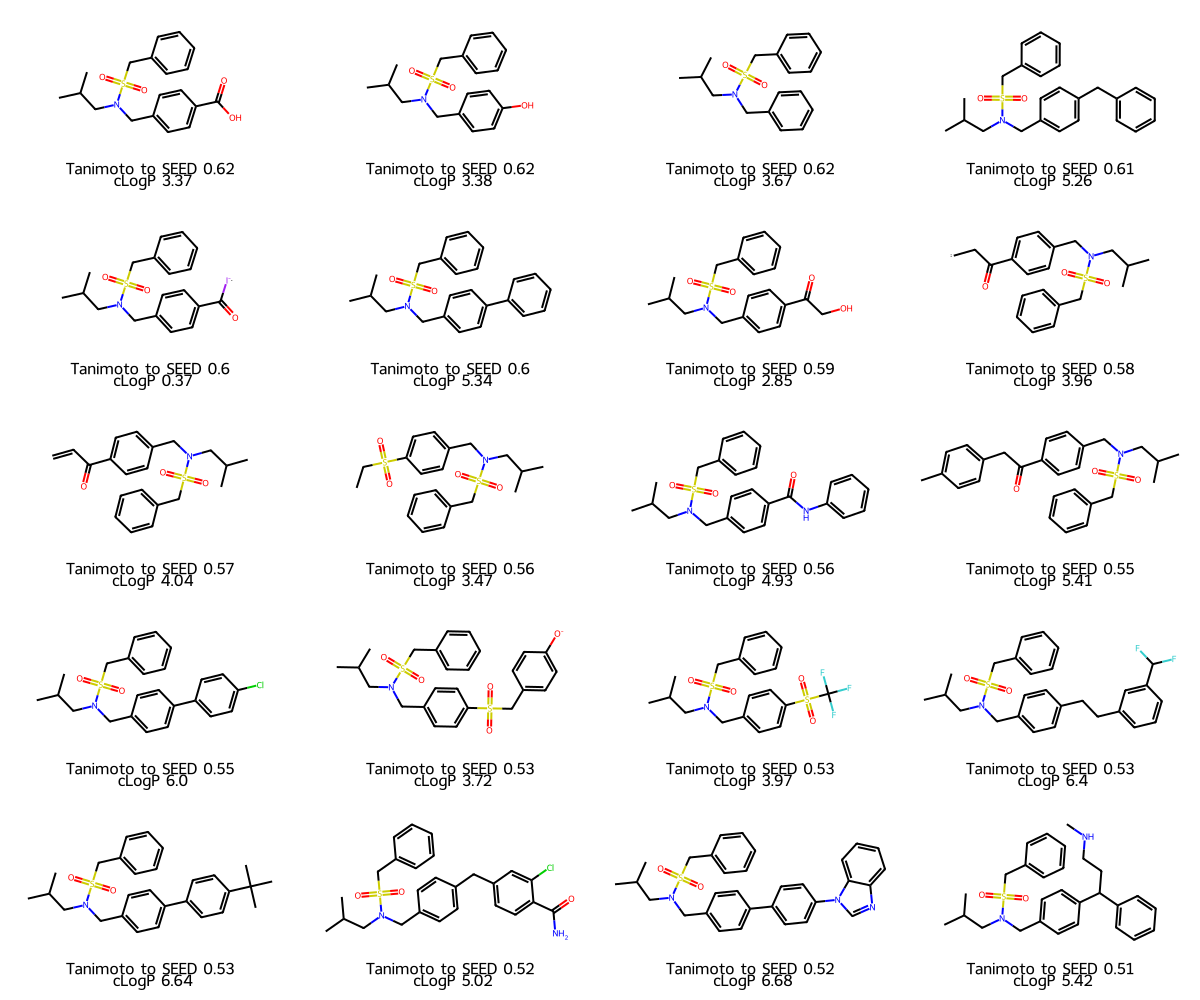

In [138]:
smiles_list = df_viz['smiles'].tolist()
tanimoto_list = df_viz['tanimoto'].tolist()
clogp_list = df_viz['clogp'].tolist()

ms = [Chem.MolFromSmiles(_) for _ in smiles_list]
dopts = Draw.MolDrawOptions()
dopts.legendFontSize=16
dopts.legendFraction=0.2
Draw.MolsToGridImage(ms,
                     molsPerRow=4,
                     subImgSize=(300, 200),
                     legends = [f"Tanimoto to SEED {tanimoto}\n cLogP {clogp}" for tanimoto, clogp in zip(tanimoto_list, clogp_list)],
                     drawOptions=dopts,
                     )

### Filter molecules according to favorable drug-like properties

Pennington, L. D.; *et al.* "[Property-Based Drug Design Merits a Nobel Prize](https://pubs.acs.org/doi/10.1021/acs.jmedchem.4c01345)." *J. Med. Chem.* **2024**, *67*, 11452-11458.

In [139]:
def filter_smiles_druglike_properties(smiles_list):
    """
    For each SMILES in the input list, returns True if it passes all filters, False otherwise.
    Filters:
    - molecular_weight <= 500
    - clogp <= 4.0
    - n_aromatic <= 3
    - TPSA <= 140
    - fsp3 >= 0.3
    Returns a list of booleans of the same length as smiles_list.
    """
    from rdkit import Chem
    from rdkit.Chem import Descriptors, rdMolDescriptors
    results = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            results.append(False)
            continue
        mw = Descriptors.MolWt(mol)
        clogp = Descriptors.MolLogP(mol)
        n_aromatic = rdMolDescriptors.CalcNumAromaticRings(mol)
        tpsa = Descriptors.TPSA(mol)
        fsp3 = rdMolDescriptors.CalcFractionCSP3(mol)
        if (
            mw <= 500 and
            clogp <= 4.0 and
            n_aromatic <= 3 and
            tpsa <= 140 and
            fsp3 >= 0.3
        ):
            results.append(True)
        else:
            results.append(False)
    return results

In [140]:
initial_size = len(smiles_list)
filtered_smiles_list = filter_smiles_druglike_properties(smiles_list)
df_viz['druglike_filter'] = filtered_smiles_list


In [141]:
df_viz_filtered = df_viz[df_viz['druglike_filter']==True] # keep only those SMILES that meet drug-like filter criteria
df_viz_filtered.head()


,smiles,tanimoto,clogp,druglike_filter
17,CC(C)CN(Cc1ccc(C(=O)O)cc1)S(=O)(=O)Cc1ccccc1,0.62,3.37,True
16,CC(C)CN(Cc1ccc(O)cc1)S(=O)(=O)Cc1ccccc1,0.62,3.38,True
14,CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1,0.62,3.67,True
19,CC(C)CN(Cc1ccc(C(=O)[I-])cc1)S(=O)(=O)Cc1ccccc1,0.60,0.37,True
18,CC(C)CN(Cc1ccc(C(=O)CO)cc1)S(=O)(=O)Cc1ccccc1,0.59,2.85,True


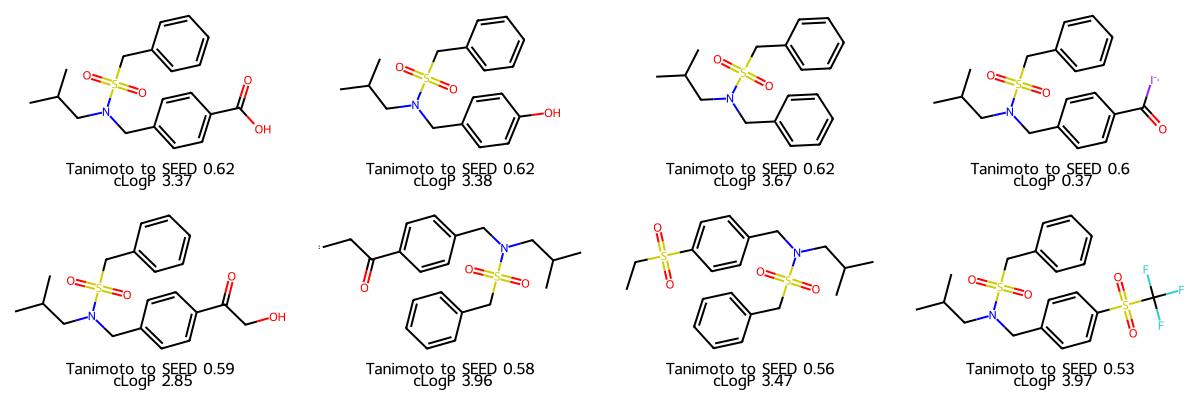

In [142]:
smiles_list = df_viz_filtered['smiles'].tolist()
tanimoto_list = df_viz_filtered['tanimoto'].tolist()
clogp_list = df_viz_filtered['clogp'].tolist()

ms = [Chem.MolFromSmiles(_) for _ in smiles_list]
dopts = Draw.MolDrawOptions()
dopts.legendFontSize=16
dopts.legendFraction=0.2
Draw.MolsToGridImage(ms,
                     molsPerRow=4,
                     subImgSize=(300, 200),
                     legends = [f"Tanimoto to SEED {tanimoto}\n cLogP {clogp}" for tanimoto, clogp in zip(tanimoto_list, clogp_list)],
                     drawOptions=dopts,
                     )

## 2.5 Preprocess the Generated Small Molecules for use in `DiffDock`

In [143]:
# choose the first N molecules from the individual runs to use for docking,
# for demo purpose we will set it to 5 for now.
N_molecules_for_docking = 5

# choose the first N molecules
# list is prioritized by highest Tanimoto similarity, highest QED score
molecules = smiles_list[:N_molecules_for_docking]

print(molecules)

['CC(C)CN(Cc1ccc(C(=O)O)cc1)S(=O)(=O)Cc1ccccc1', 'CC(C)CN(Cc1ccc(O)cc1)S(=O)(=O)Cc1ccccc1', 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'CC(C)CN(Cc1ccc(C(=O)[I-])cc1)S(=O)(=O)Cc1ccccc1', 'CC(C)CN(Cc1ccc(C(=O)CO)cc1)S(=O)(=O)Cc1ccccc1']


In [144]:
def prepare_output_directory(output):
    """
    Prepare the output directory
    output: str, the output directory
    return: None
    """
    # overwrite the output directory
    if os.path.exists(output):
        shutil.rmtree(output)
    os.makedirs(output)

Convert SMILES to SDF (generate 1 conformer for each SMILES)

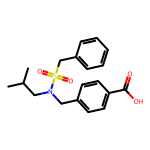

Converted SMILES to SDF: CC(C)CN(Cc1ccc(C(=O)O)cc1)S(=O)(=O)Cc1ccccc1


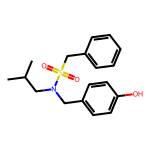

Converted SMILES to SDF: CC(C)CN(Cc1ccc(O)cc1)S(=O)(=O)Cc1ccccc1


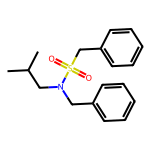

Converted SMILES to SDF: CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1


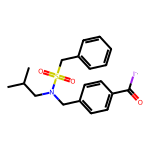

Converted SMILES to SDF: CC(C)CN(Cc1ccc(C(=O)[I-])cc1)S(=O)(=O)Cc1ccccc1


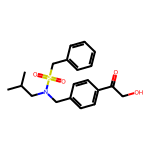

Converted SMILES to SDF: CC(C)CN(Cc1ccc(C(=O)CO)cc1)S(=O)(=O)Cc1ccccc1
['/content/output/molmim_result/clean_mols/molecule_0.sdf', '/content/output/molmim_result/clean_mols/molecule_1.sdf', '/content/output/molmim_result/clean_mols/molecule_2.sdf', '/content/output/molmim_result/clean_mols/molecule_3.sdf', '/content/output/molmim_result/clean_mols/molecule_4.sdf']


In [145]:
output_dir = "/content/output/molmim_result"
output_dir_clean = os.path.join(output_dir, "clean_mols")
prepare_output_directory(output_dir_clean)

# convert to SDF
output_sdf_files = []
for i, smiles in enumerate(molecules):
    mol_2d = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol_2d)
    AllChem.EmbedMolecule(mol)
    AllChem.UFFOptimizeMolecule(mol)
    img = Draw.MolToImage(mol_2d, size=(150, 150))
    display(img)

    # save the clean file
    path = f"{output_dir_clean}/molecule_{i}.sdf"
    w = Chem.SDWriter(path)
    w.write(mol)
    w.close()
    print(f"Converted SMILES to SDF: {smiles}")
    output_sdf_files.append(path)

# here are the paths to the generated molecules in SDF format, which can be used for docking
print(output_sdf_files)

### Download SDF files which need to be uploaded in Step 3 - Using DiffDock to Predict Docking Poses

In [ ]:
# Step 1: Zip the directory
zip_filename = "clean_mols.zip"
!cd {output_dir_clean} && zip -r {zip_filename} .

  adding: molecule_4.sdf (deflated 79%)
  adding: molecule_0.sdf (deflated 78%)
  adding: molecule_3.sdf (deflated 78%)
  adding: molecule_2.sdf (deflated 79%)
  adding: molecule_1.sdf (deflated 78%)


In [ ]:
# Step 2: Download the zipped file
from google.colab import files
files.download(os.path.join(output_dir_clean, zip_filename))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>